<h1 style="color:#ff00aa; padding:20px; text-align:center; font-size:28px; border-top-left-radius:10px; border-top-right-radius:10px;background:#170052; border:2px solid #0bbdb7; margin:0px;">Brest Cancer Detection Using CNN</h1>
<img src="https://www.silabs.com/content/dam/siliconlabs/images/solutions/ai-ml/ai-ml-banner.png" width=100% height=auto style="margin:0px;">


In [34]:
#importing librarys

# cv2 is a python extarnal package to do image processing and manipulation related stuff.
import cv2 

# imutils is a series of convenience functions to make basic image processing easy.
import imutils

# tensorflow is a python library for machine learning and artificial intelligence related work.
import tensorflow as tf 


# NumPy is a Python library used for working with arrays
import numpy as np



# Keras is a library that provides a Python interface for artificial neural networks. 
# Keras acts as an interface for the TensorFlow library.
import keras


# 1. Keras layers are the building blocks of the Keras library that can be stacked together for creating neural network models.
# 2. Keras Conv2D creates a 2D convolution kernel that is wind with layers input which helps produce a tensor of outputs.
# 3. maxpooling2D Downsamples the input along its spatial dimensions by taking the maximum value over an input window for each channel of the input. 
# 4 .Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# 5 .Dropout regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
# 6. Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


#  Model groups layers into an object with training and inference features.
from tensorflow.keras.models import Model

# tensorflow.keras.callbacks is used to visualize training of a model.
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 

# used to split dataset(features and target) into test and test
from sklearn.model_selection import train_test_split

# F1/F Score is a measure of how accurate a model is by using Precision and Recall following the 
# formula of: F1_Score = 2 * ((Precision * Recall) / (Precision + Recall)) 
# Precision is commonly called positive predictive value.
from sklearn.metrics import f1_score

# shuffle the dataset for a even mixture of each type of feature and target.it gives better result.
from sklearn.utils import shuffle

# A one hot encoding allows the representation of categorical data to be more expressive.
from sklearn.preprocessing import OneHotEncoder

# confusion matrix is used to evaluate the accuracy of a classification.[[TP,FP],[FN,TN]]
# A classification report is a performance evaluation metric in machine learning. 
# It is used to show the precision, recall, F1 Score, and support of your trained classification model.
from sklearn.metrics import confusion_matrix,classification_report

# The OS module in Python provides functions for interacting with the operating system.
import os

# Matplotlib is a data visualization and graphical plotting library for Python.
import matplotlib.pyplot as plt

# seaborn is alse a data visualization and graphical plotting library for Python.
import seaborn as sn

# used to display markdown,image,control (frontend utilities)
from IPython import display

# to subpress warning
import warnings
warnings.filterwarnings("ignore")


# dataset path 
path = "D:/Image_datasets/breast_cancer_image_dataset/Dataset_BUSI_with_GT/"
# make sure in this dir two folder named "yes" and "no" is present. 

In [35]:
# GPU Info 
try:
    import GPUtil
except:
    !pip install GPUtil
    import GPUtil

    
# check physical computing devices
device=tf.config.experimental.list_physical_devices()
for i in device:
    print(i)
if len(device)>1:
    # find GPU details
    print("="*20, "GPU Details", "="*20)
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(gpu_id,gpu.name, gpu.driver,gpu.memoryTotal,gpu.temperature)



PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# data processing portion
### Contour croping of image
> the function crop_contour_img() crop the images and remove the unnessary portion of the image and filter for better >  > > result. It also plot the after-before effect. just set the plot=True.make sure you have inastalled requirements.
#### parameters

image : type-cv2image : get the matrix type image<br>
plot : binary data [True / False] : permission to plot after-before of image.

In [36]:
# this function crop out the unnecessary part of a image.
# it takes two parameter -> image : numpy/cv2 image array , plot : binary (You want to plot after before effect of the image)

def crop_contour_img(image, plot=False):
    # convert the image into gray scale
    grayscale=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur the image
    grayscale=cv2.GaussianBlur(grayscale,(5,5),0)
    # binary thresholding the image
    threshhold_image=cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    # erode() method is used to perform erosion on the image.
    threshhold_image=cv2.erode(threshhold_image,None,iterations=2)
    # Dilation adds pixels to the boundaries of objects in an image, while erosion removes pixels on object boundaries.
    threshhold_image=cv2.dilate(threshhold_image,None,iterations=2)
    
    # find the best bounded box of the image content.
    countour=cv2.findContours(threshhold_image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    countour=imutils.grab_contours(countour)
    c=max(countour, key=cv2.contourArea)
    # calculate the corner points
    extreme_pnts_left=tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right=tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top=tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot=tuple(c[c[:, :, 1].argmax()][0])
    
    # crop out the blank area from the image.
    new_image = image[extreme_pnts_top[1]:extreme_pnts_bot[1],extreme_pnts_left[0]:extreme_pnts_right[0]]
    
    # binary threshholding the image to clean the gray scale range and makes the image binary colored based on range.
#     to remove thresh holding comment the next line
    new_image= cv2.threshold(new_image, 100, 255, cv2.THRESH_BINARY,cv2.CHAIN_APPROX_SIMPLE)[1]
    if plot:
        # plots the after before effect on the image based on parameter plot
        # plot if plot=true, ignore the if block if plot=False
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("original image")
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("processed image")
        plt.show()
        
    return new_image

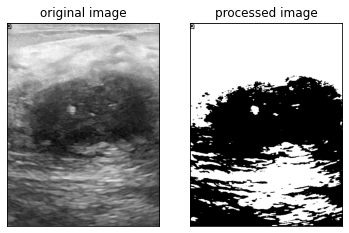

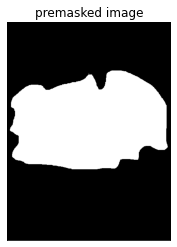

In [37]:

example_image=cv2.imread(path+"/malignant/malignant (1).png")
img=crop_contour_img(example_image,True)
premasked_image=cv2.imread(path+"/malignant/malignant (1)_mask.png")
# premasked_image=cv2.bitwise_not(premasked_image)
plt.imshow(premasked_image)
plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
plt.title("premasked image")
print()

In [57]:


# make sure root folder contains segmanted data folders"





# view directory tree
def tree_printer(root):
    import os
    try:
        if not os.path.isdir(root) and root!="":
            print(root,": path not exists....")
            return
        if ":" not in root:
            root=os.getcwd().replace("\\","/")+root
            print(root)
    except:
        print("🛠️ set path of the data set from your local mechine")
        return
    
    
    print("🗁",root)
    for d in os.listdir(root):
        try:
            print(" |- 🗁",d," "*2+"📍",len(os.listdir(os.path.join(root, d))),"items")
        except:
            continue
            
tree_printer(path)

🗁 D:/Image_datasets/breast_cancer_image_dataset/Dataset_BUSI_with_GT/
 |- 🗁 benign   📍 891 items
 |- 🗁 malignant   📍 421 items
 |- 🗁 normal   📍 266 items


In [39]:
image_size=(128,128) # defining the image size 
encoder = OneHotEncoder() # calling the OneHotEncoder
encoder.fit([[0], [1]]) # using binary crossentropy over catagorical crossentropy

def load_images(path,type="png",target=0,images=[],result=[]):
    for filepath in os.listdir(path):
        if filepath.split(".")[-1].lower()=="png" and "mask" in filepath:
            img=cv2.imread(path+"/"+filepath)
             # filtering the image
#             img=crop_contour_img(img)
            # resizing the image in defined size
            img=cv2.resize(img,image_size)
            # putting in image array
            img=np.array(img)
            # putting in image array
            images.append(img)
            result.append(encoder.transform([[target]]).toarray())
    
    return [images,result]

def show_image(datasets,num=4):  
    for i in range(num**2):
        plt.subplot(num, num, i+1)
        plt.imshow(datasets[i])
        plt.title(i+1)
        plt.axis('off')

        
def prepare_image_target(path,result):
    img=cv2.imread(path)
    img=crop_contour_img(img,True)
    img=cv2.resize(img,(128,128))
    img=np.array(img)
    img=img.reshape(1,128,128,3)
    img=img.reshape(-1)
    if result=="yes":
        return [img,[1]]
    else:
        return [img,[0]]
    
def analysis_nn_pred(pred,org,tags=[1,0]):
    accurate=0
    for i in range(len(pred)):
        print(i,")  predicted :",tags[np.array(pred[i]).argmax()],end=" | ")
        print("Original :",tags[np.array(org[i]).argmax()], end=" | ")
        if np.array(pred[i]).argmax()==np.array(org[i]).argmax():
            print("accurate : Yes.")
            accurate+=1
        else:
            print("accurate : No.")
    print("\n"+("-")*10+"score"+("-")*10)
    print("accurate=",accurate,"/",len(pred)," | accuracy=",round((accurate/len(pred)*100),3),"%")
    return (accurate/len(pred)*100)
        


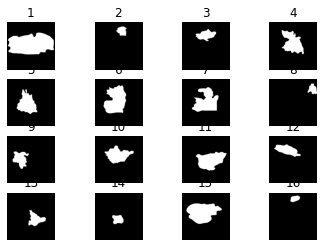

In [40]:
# yes
yes_images,yes_result=load_images(path+"/malignant",target=0,images=[],result=[])
# print(images.shape)
show_image(yes_images)
# print(result)


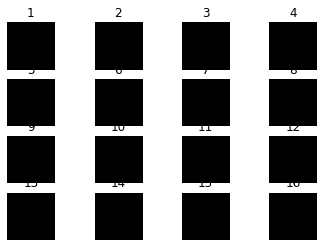

In [41]:
# no
no_images,no_result=load_images(path+"/normal",target=1,images=[],result=[])
# print(images.shape)
show_image(no_images)
# print(result)


In [42]:
images=yes_images+no_images
result=yes_result+no_result

data=np.array(images)
print(data.shape)
print(len(result))

(344, 128, 128, 3)
344


In [43]:
target=np.array(result)
print(target.shape)
target=target.reshape(len(result),2)
print(target.shape)
# print(target)

(344, 1, 2)
(344, 2)


### validation of data,original data and target

In [44]:
new_target=[]
for i in target:
    
    if i[0]==1.:
        new_target.append([1])
    else:
        new_target.append([0])

new_target=np.array(new_target)
# new_target

In [45]:
new_data=[]
for i in data:
    new_data.append(i.reshape(-1))

new_data=np.array(new_data)


# Model buliding process

In [46]:
def get_model():
    model = keras.Sequential()

    model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
    model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
    
    return model
model=get_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)       

In [47]:
print(data.shape,target.shape)
x_train,x_test,y_train,y_test=train_test_split(data, target, test_size=0.2, shuffle=True, random_state=0)


(344, 128, 128, 3) (344, 2)


In [48]:
cnn = model.fit(x_train, y_train, epochs = 15, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/15
7/7 [==============================] - 11s 1s/step - loss: 0.3760 - val_loss: 1.4487
Epoch 2/15
7/7 [==============================] - 7s 953ms/step - loss: 9.7737e-06 - val_loss: 1.2813
Epoch 3/15
7/7 [==============================] - 7s 951ms/step - loss: 2.8177e-08 - val_loss: 0.9554
Epoch 4/15
7/7 [==============================] - 7s 961ms/step - loss: 7.5834e-06 - val_loss: 0.8740
Epoch 5/15
7/7 [==============================] - 7s 972ms/step - loss: 2.3920e-04 - val_loss: 0.8773
Epoch 6/15
7/7 [==============================] - 7s 984ms/step - loss: 8.9616e-06 - val_loss: 0.9008
Epoch 7/15
7/7 [==============================] - 7s 972ms/step - loss: 1.6473e-08 - val_loss: 0.9312
Epoch 8/15
7/7 [==============================] - 7s 992ms/step - loss: 9.6661e-07 - val_loss: 0.9659
Epoch 9/15
7/7 [==============================] - 7s 989ms/step - loss: 7.7440e-06 - val_loss: 1.0036
Epoch 10/15
7/7 [==============================] - 7s 975ms/step - loss: 6.1846e-05 - va

# performance inspection

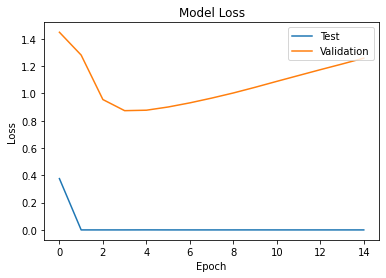

In [49]:
# plotting loss
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [50]:
res = model.predict_on_batch(x_test)

# index 0 : no tumor
# index 1 : tumor
accuracy=analysis_nn_pred(res,y_test,["tumor","No tumor"])


0 )  predicted : tumor | Original : tumor | accurate : Yes.
1 )  predicted : tumor | Original : tumor | accurate : Yes.
2 )  predicted : tumor | Original : tumor | accurate : Yes.
3 )  predicted : No tumor | Original : No tumor | accurate : Yes.
4 )  predicted : tumor | Original : tumor | accurate : Yes.
5 )  predicted : No tumor | Original : No tumor | accurate : Yes.
6 )  predicted : tumor | Original : tumor | accurate : Yes.
7 )  predicted : No tumor | Original : No tumor | accurate : Yes.
8 )  predicted : No tumor | Original : No tumor | accurate : Yes.
9 )  predicted : tumor | Original : tumor | accurate : Yes.
10 )  predicted : tumor | Original : tumor | accurate : Yes.
11 )  predicted : No tumor | Original : No tumor | accurate : Yes.
12 )  predicted : tumor | Original : tumor | accurate : Yes.
13 )  predicted : No tumor | Original : No tumor | accurate : Yes.
14 )  predicted : No tumor | Original : No tumor | accurate : Yes.
15 )  predicted : tumor | Original : tumor | accurate

Text(0.5, 1.0, 'breast cancer detection with CNN   |    accuracy : 98.5507')

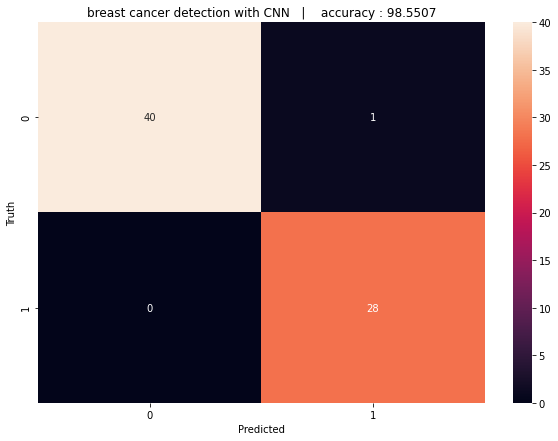

In [51]:
y_pred=model.predict(x_test)
y_pred_labels=[np.argmax(i) for i in y_pred]
y_test_labels=[np.argmax(i) for i in y_test]
cm=tf.math.confusion_matrix(labels=y_test_labels,predictions=y_pred_labels)

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with CNN   |    accuracy : "+str(round(accuracy,4)))

In [52]:
print(classification_report(y_test_labels,y_pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       0.97      1.00      0.98        28

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



# testing model on raw images.

In [53]:
def prepare_image_target(path,result):
    img=cv2.imread(path)
    img=crop_contour_img(img,True)
    img=cv2.resize(img,(128,128))
    img=np.array(img)
    img=img.reshape(1,128,128,3)
    if result=="yes":
        return [img,np.array([1.,0.])]
    else:
        return [img,np.array([[0.,1.]])]
    
    
    

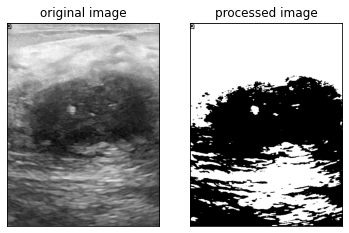

[[1. 0.]] [1. 0.]
0 )  predicted : tumor | Original : tumor | accurate : Yes.

----------score----------
accurate= 1 / 1  | accuracy= 100.0 %


100.0

In [54]:

test_img,test_target=prepare_image_target(path+"/malignant/malignant (1).png","yes")
test_pred=model.predict_on_batch(test_img)
print(test_pred,test_target)
analysis_nn_pred(test_pred,test_target,["tumor","No tumor"])

# storing the trained model in files for future use in webapp 

In [55]:
def storeData(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model.h5")
    
from keras.models import model_from_json
def loaddata():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

In [63]:
# !git add -A
# !git commit -m "updated project"
# !git status
# !git push

The file will have its original line endings in your working directory


[main d280fc5] updated project
 3 files changed, 1173 insertions(+), 45 deletions(-)
 create mode 100644 sub_code/breast_cancer_detection_with_CNN.ipynb
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


remote: This repository moved. Please use the new location:        
remote:   https://github.com/tirtharajsinha/Breast_cancer_detection_with_CNN.git        
To https://github.com/tirtharajsinha/Breast_cancer_detection_with_GAN.git
   58eda45..d280fc5  main -> main
